In [1]:
# Suppress FutureWarning
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Import required libraries and dependencies
import pandas as pd
#import hvplot.pandas
from pathlib import Path
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

#from sklearn.neighbors import NearestNeighbors
#from utils.fidatabase import TTR
#from utils.fidatabase import RTT

#import refinitiv.data as rd
#from refinitiv.data.content import symbol_conversion

#import pandas_market_calendars as mcal
import datetime as dt

import os
from pathlib import Path
#from io import BytesIO
#from zipfile import ZipFile
#from urllib.request import urlopen
#from urllib.parse import urlencode
#from string import ascii_uppercase as alc

import numpy as np
import re

#import requests 
from random import random

#from sklearn.neighbors import NearestNeighbors


In [2]:
first_ratetickers = pd.read_csv("first_ratetickers-list.csv", index_col="Ticker", parse_dates=True, keep_default_na=False) #,  infer_datetime_format=True)

first_ratetickers.columns = ['Name','start_date','end_date']
first_ratetickers["start_date"] = pd.to_datetime(first_ratetickers["start_date"], format='%Y-%m-%d').dt.tz_localize('America/New_York')
first_ratetickers["end_date"] = pd.to_datetime(first_ratetickers["end_date"], format='%Y-%m-%d').dt.tz_localize('America/New_York')


In [3]:
#
# Read comp files and run analysis
#

printed=False
swindow_list =  os.listdir("./comp_data")
ticker_window_list = {}
ticker_window_count = {}

regex = r"comps-(\d{4}\-\d{2}\-\d{2})\-(\d{4}\-\d{2}\-\d{2}).csv$"


for swindow in swindow_list:
    sdate = None
    edate = None
    
    matches = re.search(regex, swindow)
    if matches:
        sdate = pd.Timestamp(matches.group(1))
        edate = pd.Timestamp(matches.group(2))
       
        print(f"Processing window start_date: {sdate} end_date: {edate}")
    else:
        print(f"Skipping {swindow}")
        continue

    tmp_df = pd.read_csv(f"./comp_data/{swindow}", index_col=0, parse_dates=True, infer_datetime_format=True, keep_default_na=False)

    i=0

    for index, row in tmp_df.iterrows():
        i+=1
        
        if( index not in first_ratetickers.index ):
            print(f"{i} Skipping {index} not in first_ratetickers")
            continue
        
        x=row.tolist()
        if(printed==False):
            print(f"{i} {index} {x}")
            printed=True
            
        if( index not in ticker_window_count.keys() ):
            
            ticker_window_count[index] = 1
            ticker_window_list[index] = [x]
        else:
            ticker_window_count[index] += 1
            ticker_window_list[index].append(x)

    del tmp_df


print(f"Done!")


Processing window start_date: 2020-06-01 00:00:00 end_date: 2020-06-03 00:00:00
1 A ['GSK', 'IIM', 'ADX', 'NAD', 'RELX', 'JFR', 'TM', 'CHT', 'BCE', 'AAPL', 'NEA', 'BR', 'CII', 'UL', 'DHR', 'EBAY', 'TMO', 'QGEN', 'MYD', 'VZ', 1.607171498148266, 1.6368973195610608, 1.6445442237102432, 1.645434721482146, 1.649385816246182, 1.668197339227656, 1.6852610018579712, 1.6904158557617903, 1.6938592252989315, 1.698560837539544, 1.7039963354389984, 1.7173581471564048, 1.7242809467652995, 1.7325806006052702, 1.7431911970773566, 1.754520135167145, 1.75826976754037, 1.7712390347177982, 1.7791988532042182, 1.7839214152464131]
Processing window start_date: 2015-10-23 00:00:00 end_date: 2015-10-27 00:00:00
Processing window start_date: 2016-07-20 00:00:00 end_date: 2016-07-22 00:00:00
Processing window start_date: 2021-10-14 00:00:00 end_date: 2021-10-18 00:00:00
Processing window start_date: 2014-08-12 00:00:00 end_date: 2014-08-14 00:00:00
Processing window start_date: 2016-04-27 00:00:00 end_date: 201

In [297]:


def row_style(row):
    if row.WindowPercent < 5:
        return pd.Series('background-color: red; color: black; precision: 1; text-align: left', row.index)
    elif row.WindowPercent < 10:
        return pd.Series('background-color: yellow; color: black; precision: 1; text-align: left', row.index)
    else:
        return pd.Series('background-color: green; color: black; precision: 1; text-align: left', row.index)



def get_comps( stock_to_lookup, comps_per_frame=3, ignore_cut=False):

    stock_window_count = ticker_window_count[stock_to_lookup]
    stock_window_list = ticker_window_list[stock_to_lookup]

    stock_comps_count = {}
    stock_comps_distance = {}
    stock_comps_name = {}

    for cmp_list in stock_window_list:
        #row = tmp_df.loc[stock_to_lookup]
        if(len(cmp_list) < 35):
            print(f"Skipping {stock_to_lookup} not enough data")


        for i in range(0, comps_per_frame):
            ckey_value = cmp_list[i]
            dkey_value = cmp_list[i+20]


            if(dkey_value < .0-1 or cmp_list[20] < .001):
                count_muiltplyer = 1
            else:
                count_muiltplyer =  cmp_list[20] / dkey_value
            

         
            if( ckey_value not in stock_comps_count.keys() ):
                stock_comps_count[ckey_value] = 1 * count_muiltplyer
                stock_comps_distance[ckey_value] = dkey_value
                stock_comps_name[ckey_value] = first_ratetickers.loc[ckey_value]["Name"]
            else:
                stock_comps_count[ckey_value] += (1 * count_muiltplyer)
                stock_comps_distance[ckey_value] += dkey_value



        
    #stock_comps_count = {k: v for k, v in sorted(stock_comps_count.items(), reverse=True, key=lambda item: item[1])}

    rc_df = pd.DataFrame.from_dict(stock_comps_count, orient='index', columns=['Window'])
    rcd_df = pd.DataFrame.from_dict(stock_comps_distance, orient='index', columns=['TDistance'])
    rcn_df =  pd.DataFrame.from_dict(stock_comps_name, orient='index', columns=['Name'])

    comps_df = pd.concat([rcn_df,rc_df,rcd_df], axis=1)
    comps_df.index.name = 'TickerIndex'

    comps_df.insert( 0, "Ticker", comps_df.index) 


    comps_df['TDistance'] = round(comps_df['TDistance'],1)
    comps_df['AvgDistance'] = round(comps_df['TDistance']/comps_df['Window'],1)
    comps_df['WindowPercent'] = round(comps_df['Window'] / stock_window_count * 100,2)

    comps_df = comps_df.sort_values(by=['Window'], ascending=False)
    comps_df['Window'] = round(comps_df['Window'],1)
    #comps_cut = comps_df['Window'].min() + (comps_df['Window'].std()*.75)
    #comps_df.drop( comps_df[ comps_df['Window'] <= comps_cut ].index , inplace=True)


    #comps_cut = comps_df['Window'].mean() + comps_df['Window'].std()
    #comps_df.drop( comps_df[ comps_df['Window'] <= comps_cut ].index , inplace=True)

    return_df = comps_df.iloc[:20].copy()

    return_df = return_df.style.apply(row_style, axis=1)

    return_df.format({
    'TDistance': '{:,.0f}'.format,
    'AvgDistance': '{:,.2f}'.format,
    'WindowPercent': '{:,.2f}'.format,
    'Window': '{:,.1f}'.format,

    })

    return_df.set_table_styles(
    [{'selector': 'th',
      'props': [('text-align', 'left')]}])  

    return_df.hide_index()

    return return_df








In [320]:
comps_df = get_comps("WBD",3)
display(comps_df)

Ticker,Name,Window,TDistance,AvgDistance,WindowPercent
PARA,Paramount Global,53.7,158,2.90,36.51
DIS,The Walt Disney Company,45.5,141,3.10,30.96
FOXA,Twenty-First Century Fox Class A,20.4,71,3.50,13.88
FOX,Twenty-First Century Fox Class B,18.5,58,3.10,12.58
CMCSA,Comcast,11.6,37,3.20,7.91
NWSA,News Class A,9.6,30,3.10,6.54
NWS,News Class B,6.8,21,3.00,4.60
GM,General Motors,4.8,19,3.90,3.24
DISH,Dish Network,4.8,19,3.90,3.24
NFLX,Netflix,4.7,18,3.80,3.19


In [304]:
comps_df.to_html("comps.html")

In [28]:
ticker_list_df = pd.read_csv("full_stock_list_m.csv", index_col="Ticker") #,  infer_datetime_format=True)



In [166]:
ticker_list = ticker_window_count.keys()

comps_windowpercent = [ {}, {}, {}, {}, {} ]


In [305]:
for ticker in ticker_list:
   
    out_filename = Path(f"./comps_out/{ticker}.html")
    print(f"Writing {out_filename}")

    comps_df = get_comps(ticker, 3)
    # comps_df_len = len(comps_df.index)

    # if(comps_df_len >= 1):
    #     comps_windowpercent[0][ticker] = comps_df.iloc[0]["WindowPercent"]
    
    # if(comps_df_len >= 2):
    #     comps_windowpercent[1][ticker] = comps_df.iloc[1]["WindowPercent"]
    
    # if(comps_df_len >= 3):
    #     comps_windowpercent[2][ticker] = comps_df.iloc[2]["WindowPercent"]
    
    # if(comps_df_len >= 4):
    #     comps_windowpercent[3][ticker] = comps_df.iloc[3]["WindowPercent"]

    # if(comps_df_len >= 5):
    #     comps_windowpercent[4][ticker] = comps_df.iloc[4]["WindowPercent"]

    
    comps_df.to_html(out_filename)


Writing comps_out/A.html
Writing comps_out/AA.html
Writing comps_out/AADI.html
Writing comps_out/AAIC.html
Writing comps_out/AAL.html
Writing comps_out/AAOI.html
Writing comps_out/AAON.html
Writing comps_out/AAP.html
Writing comps_out/AAPL.html
Writing comps_out/AAT.html
Writing comps_out/AAU.html
Writing comps_out/AAWW-DELISTED.html
Writing comps_out/AB.html
Writing comps_out/ABBV.html
Writing comps_out/ABC.html
Writing comps_out/ABCB.html
Writing comps_out/ABEO.html
Writing comps_out/ABEV.html
Writing comps_out/ABG.html
Writing comps_out/ABIO.html
Writing comps_out/ABM.html
Writing comps_out/ABMD.html
Writing comps_out/ABR.html
Writing comps_out/ABT.html
Writing comps_out/ABTX-DELISTED.html
Writing comps_out/ABUS.html
Writing comps_out/ACA.html
Writing comps_out/ACAD.html
Writing comps_out/ACB.html
Writing comps_out/ACBI-DELISTED.html
Writing comps_out/ACC-DELISTED.html
Writing comps_out/ACCO.html
Writing comps_out/ACEL.html
Writing comps_out/ACER.html
Writing comps_out/ACET.html
Wri

<Axes: ylabel='Frequency'>

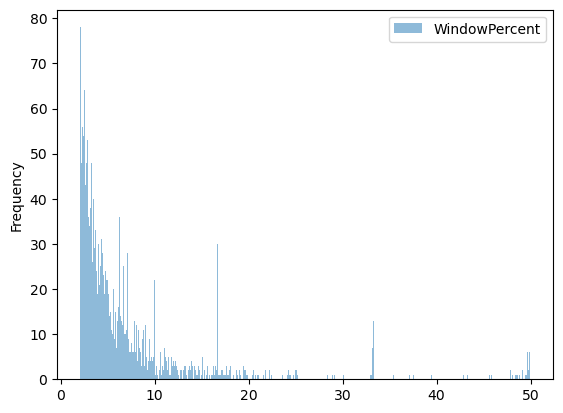

In [181]:
two_pick = pd.DataFrame(comps_windowpercent[3].values(), index=comps_windowpercent[3].keys(), columns=['WindowPercent'])
two_pick.query('WindowPercent > 2').plot.hist(bins=1000, alpha=0.5)

<Axes: ylabel='Frequency'>

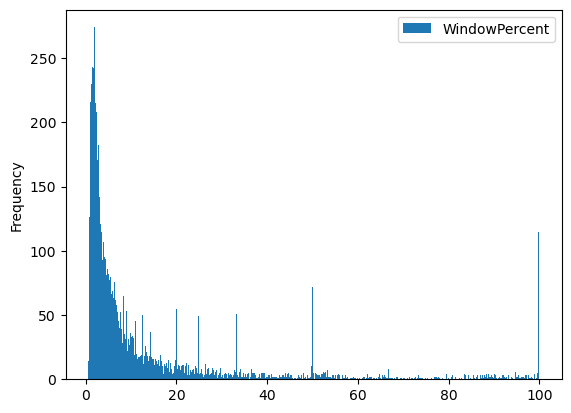

In [176]:
top_pick = pd.DataFrame(comps_windowpercent[0].values(), index=comps_windowpercent[0].keys(), columns=['WindowPercent'])
top_pick.plot.hist(bins=500)